# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import xarray as xr
import skill_metrics as sm;   import geopandas as gpd
import calendar;
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from sklearn.neighbors import BallTree
from scipy.stats import linregress

salloc --ntasks=20 --nodes=1 --partition=normal --mem-per-cpu=8GB --time=04:00:00

source $HOME/miniforge3/bin/activate

### Defined Functions

In [2]:
def noaa_data(begin,end,station,vdatum='NAVD',interval='6',
                       form='json',t_zone='GMT',unit='metric',product='water_level'):
    '''
    This function is used to get the data from NOAA API
    :param begin: begin date of the data
    :param end: end date of the data
    :param station: noaa station id
    :param vdatum: vertical datum such as NAVD
    :param interval: interval of the data (6 minutes)
    :param form: format of the data (json)
    :param t_zone: time zone of the data (GMT)
    :param unit: unit of the data (metric)
    :param product: type of the data (water_level)
    '''
    api = f'https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={begin}&end_date={end}&station={station}'\
         f'&product={product}&application=NOS.COOPS.TAC.WL&datum={vdatum}&interval={interval}&time_zone={t_zone}&units={unit}&format={form}'
    data = requests.get(url=api).content.decode()
    return data


def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def point_lookup(model_lat:np.array, model_lon:np.array, satellite_lat:np.array, satellite_lon:np.array):
    tree = BallTree(np.deg2rad(np.c_[model_lat,model_lon]), metric='haversine')
    distances, indices = tree.query(np.deg2rad(np.c_[satellite_lat, satellite_lon]), k = 1)
    return distances*6371,indices


#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [3]:
root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database')

#ncfile = nc4.Dataset(root / '2023' /'outputs' / 'fort.63.nc')

#### Read metadata within netcdf file

_____________________________________

In [4]:
stations = {'prudhoe':{'id':9497645,'lat':70.414987,'lon':-148.537066},
            'red':{'id':9491094,'lat':67.573874,'lon':-164.066624},
            'nome':{'id':9468756,'lat':64.486464,'lon':-165.450185},
            'unalakleet':{'id':9468333,'lat':63.881322,'lon':-160.820145},
            'paul':{'id':9464212,'lat':57.228635,'lon':-170.241801}}

In [ ]:
resample_time = 'D'
years = ['2024','2023','2022','2021','2020','2019',
         '2018','2017','2016','2015','2014','2013']
name = 'nome'

obs_lat = stations[name]['lat']
obs_lon = stations[name]['lon']
df_list = []
for year in years:
    ncfile = nc4.Dataset(root / year /'outputs' / 'fort.63.nc')
    start = pd.to_datetime(ncfile.variables['time'].base_date)
    dt = pd.date_range(start=start,freq='1h',periods=ncfile.dimensions['time'].size)
    x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]
    distances,node_ids = point_lookup(y, x,obs_lat,obs_lon)
    model = ncfile.variables['zeta'][:,node_ids[0][0]]
    df = pd.DataFrame({'dt': dt, 'data': model})
    df_daily_max = df.resample(resample_time, on='dt').max().reset_index()
    df_daily_max["Year"] = df_daily_max["dt"].dt.year
    df_list.append(df_daily_max)

In [ ]:
df_daily_wse = pd.concat(df_list, ignore_index=True)
df_daily_wse = df_daily_wse.iloc[1:].reset_index(drop=True)
df_annual_max = df_daily_wse.groupby("Year")["data"].max().reset_index()
slope_annual, intercept_annual, r_value, p_value, std_err = linregress(df_annual_max["Year"], df_annual_max["data"])
df_annual_max["Expected_WSE"] = df_annual_max["Year"] * slope_annual + intercept_annual
df_daily_wse["Year"] = df_daily_wse["dt"].dt.year
df_daily_wse["Month"] = df_daily_wse["dt"].dt.month

: 

In [10]:
#**Define Seasons**
seasons = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Fall": [9, 10, 11]
}

# **Assign Colors to Months**
colors = ['#8E86B5','#117733','#44AA99','#88CCEE',
          '#DDCC77','#CC6677','#AA4499','#C5779E',
          '#448FAA','#DDA377','#18B56E','#BDF356']

season_colors = {
    "Winter": {12: colors[0], 1: colors[1], 2: colors[2]},
    "Spring": {3: colors[3], 4: colors[4], 5: colors[5]},
    "Summer": {6: colors[6], 7: colors[7], 8: colors[8]},
    "Fall": {9: colors[9], 10: colors[10], 11: colors[11]}
}


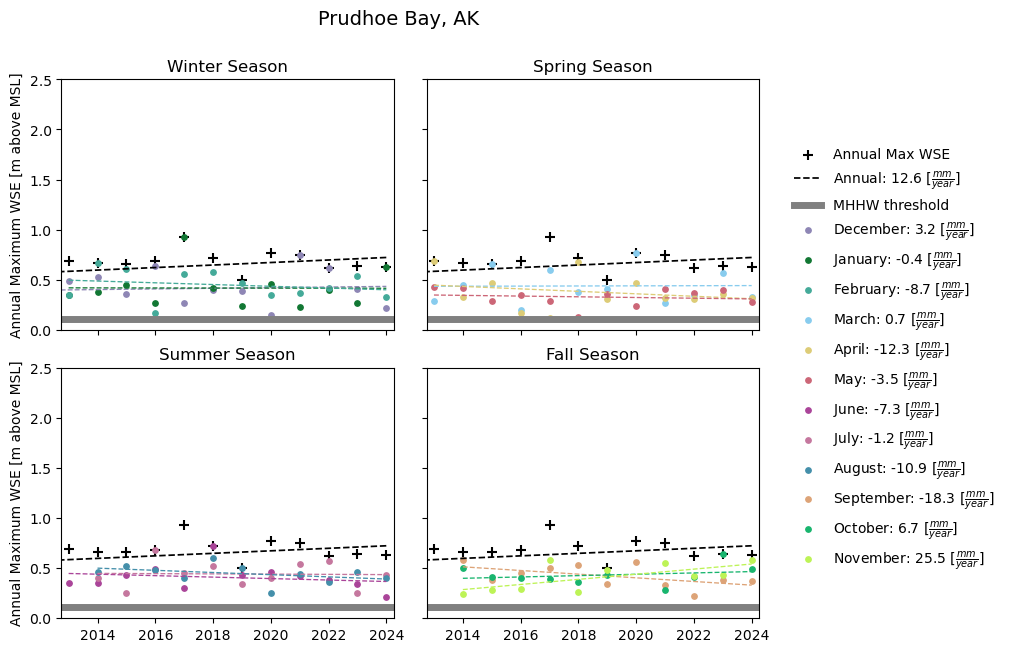

In [ ]:

df_monthly_max = df_daily_wse.groupby(["Year", "Month"])["data"].max().reset_index()
slope_annual, intercept_annual, _, _, _ = linregress(df_annual_max["Year"], df_annual_max["data"])
df_annual_max["Expected_WSE"] = df_annual_max["Year"] * slope_annual + intercept_annual

thresh = 0.215
fig, axs = plt.subplots(2, 2, figsize=(9, 7), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten into a 1D array for easier access
plt.subplots_adjust(wspace=0.1, hspace=0.15)
legend_handles = {}
for idx, (season, months) in enumerate(seasons.items()):
    ax = axs[idx]
    threshold = ax.axhline(thresh, linestyle="-", linewidth=5,color='grey',label='MHHW threshold')
    scatter_annual=ax.scatter(df_annual_max["Year"], df_annual_max["data"], label="Annual Max WSE", color="k", s=50,marker='+')
    trend_annual,=ax.plot(df_annual_max["Year"], df_annual_max["Expected_WSE"], color="k", linestyle="--",linewidth=1.25,
            label=f"Annual: {slope_annual*1000:.1f} "+r'$[\frac{mm}{year}]$')
    #p95_line, = ax.plot(df_percentiles["Year"], df_percentiles["90th Percentile"], color="purple", linestyle="-", linewidth=1.2, label="95th Percentile")
    #p99_line, = ax.plot(df_percentiles["Year"], df_percentiles["95th Percentile"], color="darkorange", linestyle="-", linewidth=1.2, label="99th Percentile")

    if "Annual Max WSE" not in legend_handles:
        legend_handles["Annual Max WSE"] = scatter_annual
    if "Annual Trend" not in legend_handles:
        legend_handles["Annual Trend"] = trend_annual
    if "MHHW threshold" not in legend_handles:
        legend_handles["MHHW threshold"] = threshold
    '''
    if "95th Percentile" not in legend_handles:
        legend_handles["95th Percentile"] = p95_line
    if "99th Percentile" not in legend_handles:
        legend_handles["99th Percentile"] = p99_line'
    '''
    for month in months:
        df_month = df_monthly_max[df_monthly_max["Month"] == month]
        if len(df_month) > 1:  # Ensure enough data points for regression
            slope_month, intercept_month, _, _, _ = linregress(df_month["Year"], df_month["data"])
            scatter_month = ax.scatter(df_month["Year"], df_month["data"], color=season_colors[season][month], s=15,
                                       label=f"{calendar.month_name[month]}: {slope_month*1000:.1f} "+r'$[\frac{mm}{year}]$')
            trend_month, =ax.plot(df_month["Year"], df_month["Year"] * slope_month + intercept_month,
                    linestyle="--", color=season_colors[season][month], linewidth=0.95,label=f"{calendar.month_name[month]}: {slope_month*1000:.1f} "+r'$[\frac{mm}{year}]$')
            if calendar.month_name[month] not in legend_handles:
                legend_handles[calendar.month_name[month]] = scatter_month

    ax.set_ylim([-0.0001, 2.500001])
    if idx in [0, 2]:  # Winter and Summer (left-side subplots)
        ax.set_ylabel("Annual Maximum WSE [m above MSL]")
    else:  # Remove y-axis labels from right-side plots
        ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xlim([2012.75, 2024.25])
    ax.set_title(f"{season} Season")
    #ax.grid(True)
fig.legend(handles=legend_handles.values(), loc='upper right', bbox_to_anchor=(1.175, 0.8), ncol=1, frameon=False, fontsize=10)
fig.suptitle('Nome, AK', fontsize=14)

plt.savefig(f'/scratch/tmiesse/project/figures/{name}_season_trend.png',dpi=480,bbox_inches='tight',pad_inches=0.1,transparent=False)
plt.show()

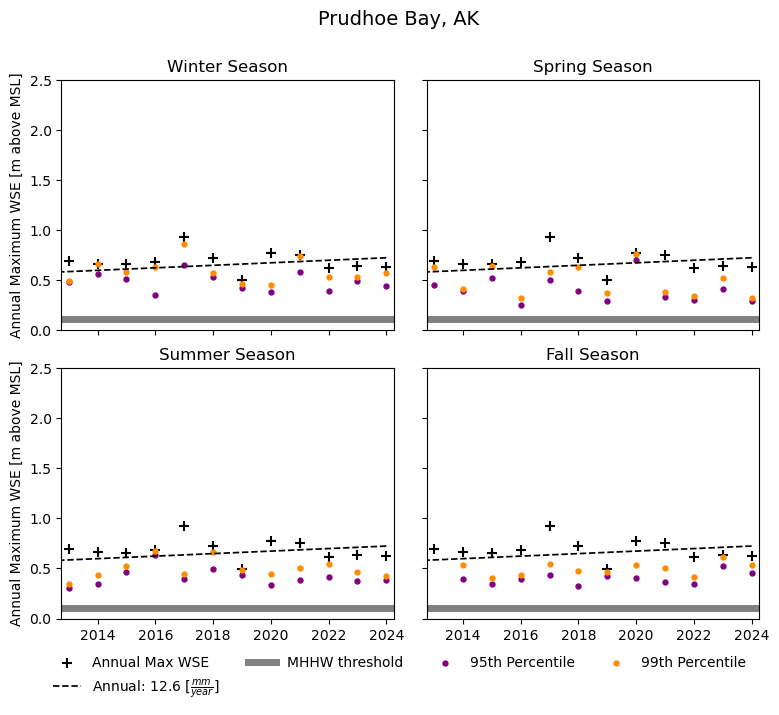

In [ ]:

df_monthly_max = df_daily_wse.groupby(["Year", "Month"])["data"].max().reset_index()
slope_annual, intercept_annual, _, _, _ = linregress(df_annual_max["Year"], df_annual_max["data"])
df_annual_max["Expected_WSE"] = df_annual_max["Year"] * slope_annual + intercept_annual
df_percentiles = df_daily_wse.groupby(["Year", "Month"])["data"].quantile([0.95, 0.99]).unstack().reset_index()
df_percentiles.columns = ["Year", "Month", "95th Percentile", "99th Percentile"]

df_seasonal_max = pd.DataFrame()
for season, months in seasons.items():
    df_season = df_percentiles[df_percentiles["Month"].isin(months)]
    df_season_max = df_season.groupby("Year")[["95th Percentile", "99th Percentile"]].max().reset_index()
    df_season_max["Season"] = season
    df_seasonal_max = pd.concat([df_seasonal_max, df_season_max])

thresh = 0.215
fig, axs = plt.subplots(2, 2, figsize=(9, 7), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten into a 1D array for easier access
plt.subplots_adjust(wspace=0.1, hspace=0.15)
legend_handles = {}
for idx, (season, months) in enumerate(seasons.items()):
    ax = axs[idx]
    df_season_max = df_seasonal_max[df_seasonal_max["Season"] == season]
    df_season_annual = df_annual_max[df_annual_max["Year"].isin(df_season_max["Year"])]


    threshold = ax.axhline(thresh, linestyle="-", linewidth=5,color='grey',label='MHHW threshold')
    scatter_annual=ax.scatter(df_annual_max["Year"], df_annual_max["data"], label="Annual Max WSE", color="k", s=50,marker='+')
    trend_annual,=ax.plot(df_annual_max["Year"], df_annual_max["Expected_WSE"], color="k", linestyle="--",linewidth=1.25,
            label=f"Annual: {slope_annual*1000:.1f} "+r'$[\frac{mm}{year}]$')
    p95_scatter = ax.scatter(df_season_max["Year"], df_season_max["95th Percentile"],
                             color="purple",marker='.', s=50, label="95th Percentile")

    p99_scatter = ax.scatter(df_season_max["Year"], df_season_max["99th Percentile"],
                             color="darkorange",marker='.', s=50, label="99th Percentile")

    if "Annual Max WSE" not in legend_handles:
        legend_handles["Annual Max WSE"] = scatter_annual
    if "Annual Trend" not in legend_handles:
        legend_handles["Annual Trend"] = trend_annual
    if "MHHW threshold" not in legend_handles:
        legend_handles["MHHW threshold"] = threshold

    if "95th Percentile" not in legend_handles:
        legend_handles["95th Percentile"] = p95_scatter
    if "99th Percentile" not in legend_handles:
        legend_handles["99th Percentile"] = p99_scatter

    ax.set_ylim([-0.0001, 2.500001])
    if idx in [0, 2]:  # Winter and Summer (left-side subplots)
        ax.set_ylabel("Annual Maximum WSE [m above MSL]")
    else:  # Remove y-axis labels from right-side plots
        ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xlim([2012.75, 2024.25])
    ax.set_title(f"{season} Season")
    #ax.grid(True)
fig.legend(handles=legend_handles.values(), loc='upper right', bbox_to_anchor=(.9, 0.075), ncol=4, frameon=False, fontsize=10)
fig.suptitle('Nome, AK', fontsize=14)

plt.savefig(f'/scratch/tmiesse/project/figures/{name}_seasonal_percentiles.png',dpi=480,bbox_inches='tight',pad_inches=0.1,transparent=False)
plt.show()

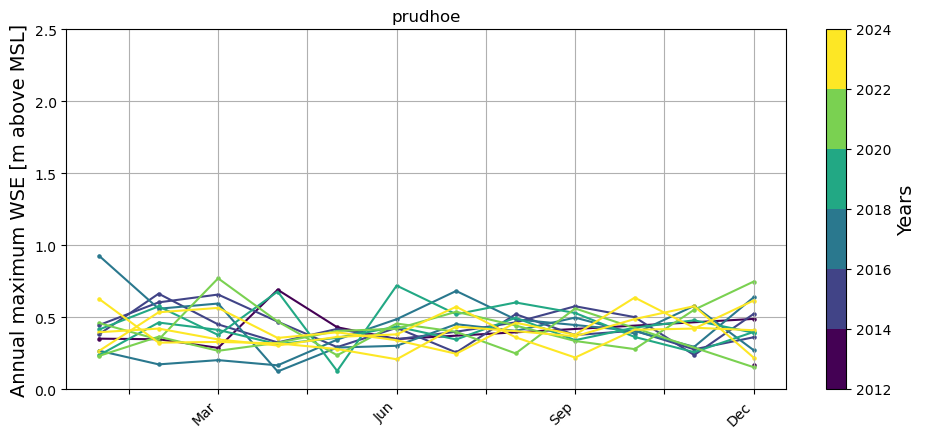

In [20]:
# plot parameters to initialize the plot
#plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,4))

ax = plt.axes([0,0.,0.9,.9])
c=0
num_classes = int(len(df_annual_max["Year"].unique())/2)
cmap = mpl.cm.get_cmap("viridis", num_classes)

# Normalize the color scale to the range of years
norm = mpl.colors.Normalize(vmin=min(df_annual_max["Year"]), vmax=max(df_annual_max["Year"]))

df_monthly_mean = df_daily_wse.groupby(["Year", "Month"])["data"].max().reset_index()
monthly_trends = {}
for year in df_monthly_mean["Year"].unique():
    df_year = df_monthly_mean[df_monthly_mean["Year"] == year]
    
    # Compute trend for the month
    slope_month, intercept_month, r_value, p_value, std_err = linregress(df_month["Year"], df_month["data"])
    monthly_trends[month] = {"Slope": slope_month, "R²": r_value**2, "p-value": p_value}
    colors = cmap(norm(year))
    sc = ax.scatter(df_year["Month"], df_year["data"],color=colors,s=5)
    ax.plot(df_year["Month"], df_year["data"],color=colors)

    c+=1
cbar_ax = fig.add_axes([.95,0.001,0.025,0.90])
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,norm=norm,orientation='vertical')
cbar.set_label(label = r'Years',fontsize =14)

ax.set_ylabel(r'Annual maximum WSE [m above MSL]',fontsize=14)
ax.set_ylim([-0.0001,2.50001])

ax.grid(True)
#ax.legend(loc='upper right', bbox_to_anchor=(1.15, .975),ncol=1,frameon=False,fontsize=8)
ax.set_title(name)
month_names = [calendar.month_name[i] for i in range(1,13)]
ax.set_xticks(range(1, 13))
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_monthly_wl_trend.png',dpi=480,bbox_inches='tight',pad_inches=0.1,transparent=False)
plt.show()

In [19]:
num_classes

13

'December'